# Example usage notebook of the DD-GAN repo

In [1]:
import time
import numpy as np
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt


After installation of the ddgan package run the following line to import it

In [2]:
from ddgan import GAN
from ddgan import *

In [3]:
kwargs = {
    "nsteps" : 20,
    "ndims" : 15,
    "batches" : 10,
    "batch_size" : 256,
    "seed" : 143,
    "epochs" : 10000
}

gan = GAN(**kwargs)
gan.setup()
set_seed(gan.seed)

ndims_latent_input = gan.ndims

csv_data = np.load('../data/processed/pod_coeffs_field_Velocity.npy', )
csv_data = csv_data[0,:,:]

#csv_data = np.loadtxt('../data/processed/POD_coeffs_1_204_orig.csv', delimiter=',')
csv_data = np.float32(csv_data.T)

print('type and shape (nPOD by nTrain) of POD coeffs from csv file', type(csv_data), csv_data.shape, csv_data.dtype)

looking for previous saved models
making new generator and critic
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5120)              512000    
_________________________________________________________________
batch_normalization (BatchNo (None, 5120)              20480     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5120)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 4, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 4, 128)         512       
________________________________________________________

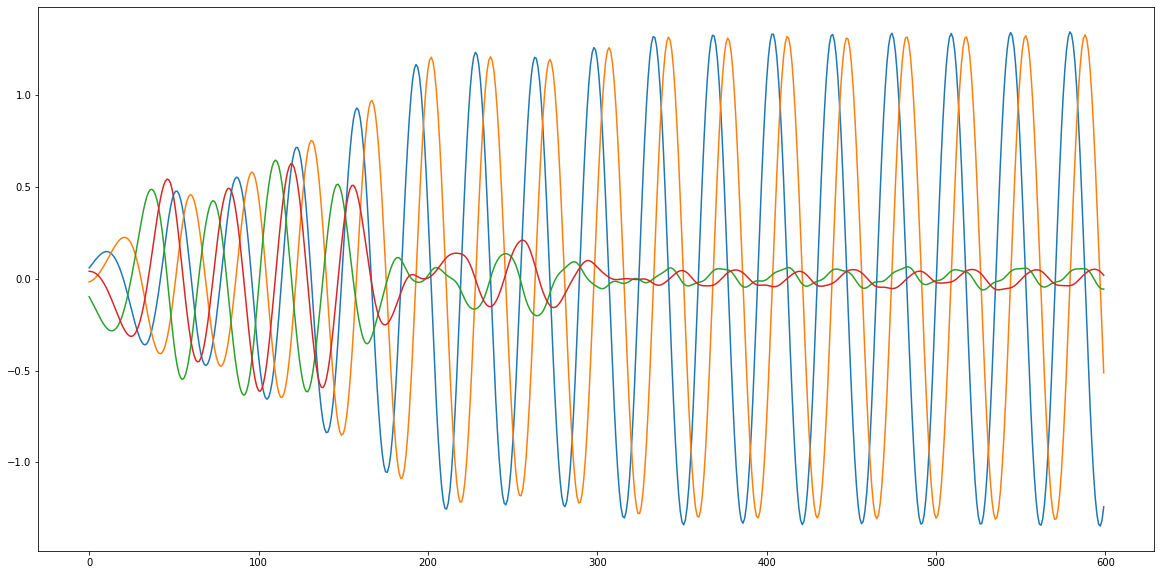

In [4]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[:600,1:5])
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(csv_data)*2 -1

In [6]:
X_train_scaled[0:401:10].shape

(41, 15)

In [7]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [8]:
codings_size = X_train_scaled.shape[1]

ntimes = 20 # Consecutive times for the GAN
step = 1 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

In [9]:
X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

In [10]:
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, gan.ndims, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(gan.batch_size)

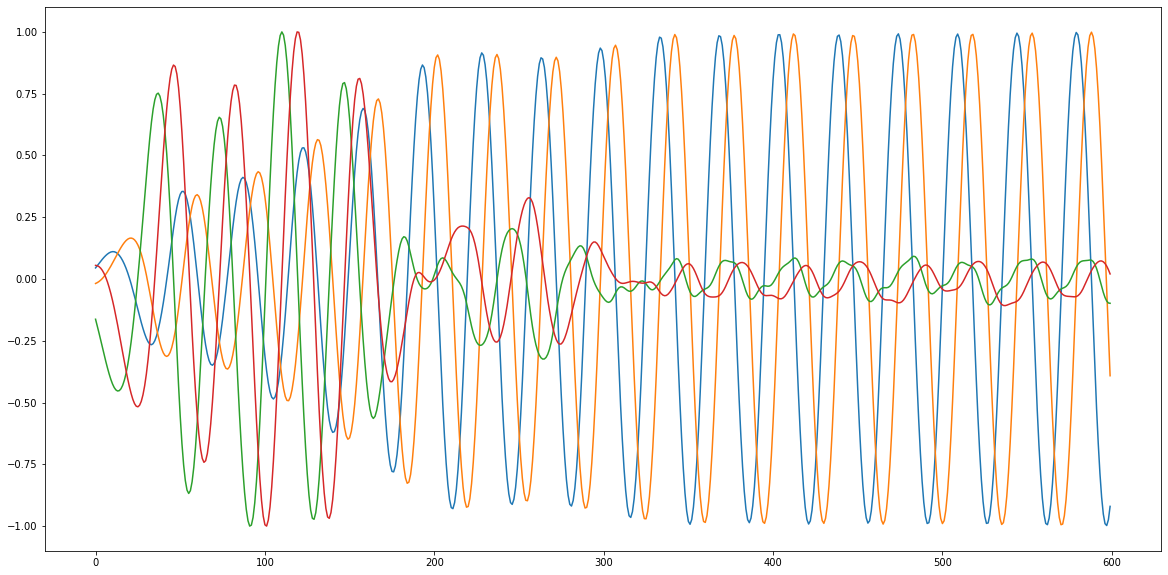

In [11]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(X_train_scaled[:600,1:5])
plt.show()

In [12]:
X_train_concat.shape

(1194, 20, 15)

t_begin = 0
t_end = nTrain - gan.nsteps + 1
training_data = np.zeros((t_end, nPOD * gan.nsteps), dtype=np.float32) # nTrain by nsteps*nPOD # 'float32' or np.float32

input_to_GAN = tf.random.normal([training_data.shape[0], gan.ndims])
input_to_GAN = input_to_GAN.numpy()

for step in range(gan.nsteps):
    training_data[:,step*nPOD:(step+1)*nPOD] = csv_data[t_begin+step : t_end+step,:]
print('Shape of training data for the GAN', training_data.shape, training_data.dtype)

In [13]:
t0 = time.time()
gan.learn_hypersurface_from_POD_coeffs(train_dataset)
t_train = time.time() - t0

beginning training
epoch: 	 0
generator loss:  0.688096 discriminator loss:  1.364986
epoch: 	 1
generator loss:  0.7196888 discriminator loss:  1.2917557
epoch: 	 2
generator loss:  0.7262866 discriminator loss:  1.2511412
epoch: 	 3
generator loss:  0.704986 discriminator loss:  1.2422174
epoch: 	 4
generator loss:  0.6873804 discriminator loss:  1.2374321
epoch: 	 5
generator loss:  0.7025646 discriminator loss:  1.2119583
epoch: 	 6
generator loss:  0.73279506 discriminator loss:  1.1831121
epoch: 	 7
generator loss:  0.75807244 discriminator loss:  1.1673399
epoch: 	 8
generator loss:  0.78522855 discriminator loss:  1.159522
epoch: 	 9
generator loss:  0.82023513 discriminator loss:  1.1522846
epoch: 	 10
generator loss:  0.87012607 discriminator loss:  1.1315572
epoch: 	 11
generator loss:  0.8737232 discriminator loss:  1.1444441
epoch: 	 12
generator loss:  0.8383468 discriminator loss:  1.1814035
epoch: 	 13
generator loss:  0.8800362 discriminator loss:  1.1655529
epoch: 	 1

generator loss:  1.7272005 discriminator loss:  0.49744874
epoch: 	 118
generator loss:  1.677391 discriminator loss:  0.48666334
epoch: 	 119
generator loss:  1.6181452 discriminator loss:  0.4950239
epoch: 	 120
generator loss:  1.5991235 discriminator loss:  0.5240169
epoch: 	 121
generator loss:  1.7219956 discriminator loss:  0.5282115
epoch: 	 122
generator loss:  1.8214031 discriminator loss:  0.4967714
epoch: 	 123
generator loss:  1.7248785 discriminator loss:  0.47270423
epoch: 	 124
generator loss:  1.6293999 discriminator loss:  0.46853393
epoch: 	 125
generator loss:  1.689949 discriminator loss:  0.4411102
epoch: 	 126
generator loss:  1.7788941 discriminator loss:  0.43720388
epoch: 	 127
generator loss:  1.776796 discriminator loss:  0.43791208
epoch: 	 128
generator loss:  1.6990532 discriminator loss:  0.45587474
epoch: 	 129
generator loss:  1.6383374 discriminator loss:  0.47523403
epoch: 	 130
generator loss:  1.6232383 discriminator loss:  0.4979022
epoch: 	 131
g

generator loss:  1.8102652 discriminator loss:  0.47841996
epoch: 	 233
generator loss:  1.7351248 discriminator loss:  0.48959523
epoch: 	 234
generator loss:  1.7199692 discriminator loss:  0.49442673
epoch: 	 235
generator loss:  1.6681979 discriminator loss:  0.51469994
epoch: 	 236
generator loss:  1.6389786 discriminator loss:  0.5401148
epoch: 	 237
generator loss:  1.5624708 discriminator loss:  0.58772707
epoch: 	 238
generator loss:  1.5646098 discriminator loss:  0.63045204
epoch: 	 239
generator loss:  1.5159757 discriminator loss:  0.6653372
epoch: 	 240
generator loss:  1.5549456 discriminator loss:  0.67927516
epoch: 	 241
generator loss:  1.5166698 discriminator loss:  0.6744658
epoch: 	 242
generator loss:  1.5562274 discriminator loss:  0.65846336
epoch: 	 243
generator loss:  1.5151603 discriminator loss:  0.6634286
epoch: 	 244
generator loss:  1.549267 discriminator loss:  0.6666899
epoch: 	 245
generator loss:  1.5323374 discriminator loss:  0.6743275
epoch: 	 246

generator loss:  1.7305368 discriminator loss:  0.58320343
epoch: 	 348
generator loss:  1.6905813 discriminator loss:  0.5915899
epoch: 	 349
generator loss:  1.705485 discriminator loss:  0.595939
epoch: 	 350
generator loss:  1.7096974 discriminator loss:  0.58494496
epoch: 	 351
generator loss:  1.8030955 discriminator loss:  0.5485422
epoch: 	 352
generator loss:  1.8358638 discriminator loss:  0.5193858
epoch: 	 353
generator loss:  1.8505313 discriminator loss:  0.48337597
epoch: 	 354
generator loss:  1.8665617 discriminator loss:  0.4731686
epoch: 	 355
generator loss:  1.8704312 discriminator loss:  0.4724346
epoch: 	 356
generator loss:  1.8539234 discriminator loss:  0.48010644
epoch: 	 357
generator loss:  1.7835983 discriminator loss:  0.5288092
epoch: 	 358
generator loss:  1.7044194 discriminator loss:  0.5558182
epoch: 	 359
generator loss:  1.6635373 discriminator loss:  0.5961791
epoch: 	 360
generator loss:  1.6454027 discriminator loss:  0.59453243
epoch: 	 361
gen

generator loss:  1.802297 discriminator loss:  0.48345476
epoch: 	 463
generator loss:  1.8998817 discriminator loss:  0.47548264
epoch: 	 464
generator loss:  1.9181595 discriminator loss:  0.47389022
epoch: 	 465
generator loss:  1.8588028 discriminator loss:  0.4852808
epoch: 	 466
generator loss:  1.8613545 discriminator loss:  0.49454564
epoch: 	 467
generator loss:  1.860342 discriminator loss:  0.50001264
epoch: 	 468
generator loss:  1.9197686 discriminator loss:  0.50504315
epoch: 	 469
generator loss:  1.9332701 discriminator loss:  0.48330504
epoch: 	 470
generator loss:  2.0321517 discriminator loss:  0.45020205
epoch: 	 471
generator loss:  2.0977051 discriminator loss:  0.42536592
epoch: 	 472
generator loss:  2.08378 discriminator loss:  0.41600543
epoch: 	 473
generator loss:  2.1325123 discriminator loss:  0.4132451
epoch: 	 474
generator loss:  2.1370442 discriminator loss:  0.4363957
epoch: 	 475
generator loss:  2.069854 discriminator loss:  0.4789629
epoch: 	 476
g

generator loss:  2.0106163 discriminator loss:  0.43921885
epoch: 	 578
generator loss:  2.060001 discriminator loss:  0.4329536
epoch: 	 579
generator loss:  2.134213 discriminator loss:  0.41375494
epoch: 	 580
generator loss:  2.085381 discriminator loss:  0.41938648
epoch: 	 581
generator loss:  2.119109 discriminator loss:  0.4164834
epoch: 	 582
generator loss:  2.1885939 discriminator loss:  0.40586677
epoch: 	 583
generator loss:  2.1233344 discriminator loss:  0.42449552
epoch: 	 584
generator loss:  2.1091237 discriminator loss:  0.4231361
epoch: 	 585
generator loss:  2.1284938 discriminator loss:  0.41607413
epoch: 	 586
generator loss:  2.1149468 discriminator loss:  0.41114435
epoch: 	 587
generator loss:  2.1454418 discriminator loss:  0.40861207
epoch: 	 588
generator loss:  2.1247134 discriminator loss:  0.40415686
epoch: 	 589
generator loss:  2.101905 discriminator loss:  0.41064468
epoch: 	 590
generator loss:  2.0973048 discriminator loss:  0.4226076
epoch: 	 591
g

generator loss:  2.4008782 discriminator loss:  0.31657287
epoch: 	 693
generator loss:  2.4235663 discriminator loss:  0.32407084
epoch: 	 694
generator loss:  2.3885417 discriminator loss:  0.3243707
epoch: 	 695
generator loss:  2.4416502 discriminator loss:  0.32518786
epoch: 	 696
generator loss:  2.3934853 discriminator loss:  0.31347138
epoch: 	 697
generator loss:  2.453917 discriminator loss:  0.31624913
epoch: 	 698
generator loss:  2.3946202 discriminator loss:  0.30887157
epoch: 	 699
generator loss:  2.4536538 discriminator loss:  0.31576425
epoch: 	 700
generator loss:  2.4176974 discriminator loss:  0.31506214
epoch: 	 701
generator loss:  2.455115 discriminator loss:  0.30989534
epoch: 	 702
generator loss:  2.3645234 discriminator loss:  0.31914315
epoch: 	 703
generator loss:  2.4411602 discriminator loss:  0.3176596
epoch: 	 704
generator loss:  2.421904 discriminator loss:  0.3097952
epoch: 	 705
generator loss:  2.5202668 discriminator loss:  0.31521136
epoch: 	 70

generator loss:  2.8347306 discriminator loss:  0.26085186
epoch: 	 808
generator loss:  2.881024 discriminator loss:  0.2572468
epoch: 	 809
generator loss:  2.8803196 discriminator loss:  0.2536541
epoch: 	 810
generator loss:  2.9405365 discriminator loss:  0.24913895
epoch: 	 811
generator loss:  2.8760955 discriminator loss:  0.24678096
epoch: 	 812
generator loss:  2.8085644 discriminator loss:  0.27070832
epoch: 	 813
generator loss:  2.840505 discriminator loss:  0.26979515
epoch: 	 814
generator loss:  2.7941012 discriminator loss:  0.26507416
epoch: 	 815
generator loss:  2.8531356 discriminator loss:  0.26520562
epoch: 	 816
generator loss:  2.9149716 discriminator loss:  0.26081425
epoch: 	 817
generator loss:  2.921198 discriminator loss:  0.26869282
epoch: 	 818
generator loss:  2.8163352 discriminator loss:  0.25430346
epoch: 	 819
generator loss:  2.898737 discriminator loss:  0.2435329
epoch: 	 820
generator loss:  2.9178245 discriminator loss:  0.2564628
epoch: 	 821


generator loss:  3.309751 discriminator loss:  0.21257338
epoch: 	 923
generator loss:  3.3808205 discriminator loss:  0.22323504
epoch: 	 924
generator loss:  3.2861145 discriminator loss:  0.21815434
epoch: 	 925
generator loss:  3.3609653 discriminator loss:  0.19823924
epoch: 	 926
generator loss:  3.3003216 discriminator loss:  0.2044032
epoch: 	 927
generator loss:  3.3588936 discriminator loss:  0.2065651
epoch: 	 928
generator loss:  3.3308175 discriminator loss:  0.20505393
epoch: 	 929
generator loss:  3.3065193 discriminator loss:  0.21467742
epoch: 	 930
generator loss:  3.3506336 discriminator loss:  0.2211781
epoch: 	 931
generator loss:  3.3208394 discriminator loss:  0.22454576
epoch: 	 932
generator loss:  3.2567716 discriminator loss:  0.21519287
epoch: 	 933
generator loss:  3.4459329 discriminator loss:  0.20438609
epoch: 	 934
generator loss:  3.3228672 discriminator loss:  0.20050105
epoch: 	 935
generator loss:  3.4114692 discriminator loss:  0.19485779
epoch: 	 

generator loss:  3.7757206 discriminator loss:  0.19160344
epoch: 	 1036
generator loss:  3.6545358 discriminator loss:  0.19090709
epoch: 	 1037
generator loss:  3.7927976 discriminator loss:  0.20273069
epoch: 	 1038
generator loss:  3.595635 discriminator loss:  0.2115432
epoch: 	 1039
generator loss:  3.6630597 discriminator loss:  0.2063916
epoch: 	 1040
generator loss:  3.6794937 discriminator loss:  0.20214391
epoch: 	 1041
generator loss:  3.8587196 discriminator loss:  0.20816545
epoch: 	 1042
generator loss:  3.6541297 discriminator loss:  0.20264545
epoch: 	 1043
generator loss:  3.7948804 discriminator loss:  0.20009919
epoch: 	 1044
generator loss:  3.6237063 discriminator loss:  0.18123414
epoch: 	 1045
generator loss:  3.6687233 discriminator loss:  0.1896785
epoch: 	 1046
generator loss:  3.8647428 discriminator loss:  0.18691832
epoch: 	 1047
generator loss:  3.6666744 discriminator loss:  0.183724
epoch: 	 1048
generator loss:  3.7759674 discriminator loss:  0.2091086

generator loss:  4.10917 discriminator loss:  0.17818849
epoch: 	 1149
generator loss:  4.025948 discriminator loss:  0.17294565
epoch: 	 1150
generator loss:  4.077887 discriminator loss:  0.17852414
epoch: 	 1151
generator loss:  4.095085 discriminator loss:  0.18213698
epoch: 	 1152
generator loss:  3.9256063 discriminator loss:  0.17028807
epoch: 	 1153
generator loss:  4.098576 discriminator loss:  0.17594147
epoch: 	 1154
generator loss:  4.0554094 discriminator loss:  0.18480094
epoch: 	 1155
generator loss:  4.025698 discriminator loss:  0.17257418
epoch: 	 1156
generator loss:  4.060549 discriminator loss:  0.17649029
epoch: 	 1157
generator loss:  4.1754575 discriminator loss:  0.17287599
epoch: 	 1158
generator loss:  4.064574 discriminator loss:  0.17614204
epoch: 	 1159
generator loss:  4.0245447 discriminator loss:  0.17501919
epoch: 	 1160
generator loss:  4.0514026 discriminator loss:  0.17181095
epoch: 	 1161
generator loss:  4.1273093 discriminator loss:  0.17661718
e

generator loss:  4.423581 discriminator loss:  0.16461447
epoch: 	 1263
generator loss:  4.2599206 discriminator loss:  0.16557202
epoch: 	 1264
generator loss:  4.3961463 discriminator loss:  0.167065
epoch: 	 1265
generator loss:  4.3683205 discriminator loss:  0.17348966
epoch: 	 1266
generator loss:  4.477495 discriminator loss:  0.16971648
epoch: 	 1267
generator loss:  4.364852 discriminator loss:  0.16957745
epoch: 	 1268
generator loss:  4.345709 discriminator loss:  0.1604389
epoch: 	 1269
generator loss:  4.3933153 discriminator loss:  0.16625813
epoch: 	 1270
generator loss:  4.3402834 discriminator loss:  0.18721764
epoch: 	 1271
generator loss:  4.3893633 discriminator loss:  0.17405307
epoch: 	 1272
generator loss:  4.480576 discriminator loss:  0.16592857
epoch: 	 1273
generator loss:  4.526971 discriminator loss:  0.16925076
epoch: 	 1274
generator loss:  4.401368 discriminator loss:  0.1593982
epoch: 	 1275
generator loss:  4.351173 discriminator loss:  0.17021649
epoc

generator loss:  4.4839816 discriminator loss:  0.17359692
epoch: 	 1377
generator loss:  4.468897 discriminator loss:  0.16939385
epoch: 	 1378
generator loss:  4.429212 discriminator loss:  0.1657567
epoch: 	 1379
generator loss:  4.543244 discriminator loss:  0.16342032
epoch: 	 1380
generator loss:  4.587833 discriminator loss:  0.16947863
epoch: 	 1381
generator loss:  4.6454535 discriminator loss:  0.16284187
epoch: 	 1382
generator loss:  4.500754 discriminator loss:  0.16056702
epoch: 	 1383
generator loss:  4.5977044 discriminator loss:  0.16258097
epoch: 	 1384
generator loss:  4.5698004 discriminator loss:  0.15477991
epoch: 	 1385
generator loss:  4.592392 discriminator loss:  0.16426514
epoch: 	 1386
generator loss:  4.524352 discriminator loss:  0.16093022
epoch: 	 1387
generator loss:  4.5255866 discriminator loss:  0.16614719
epoch: 	 1388
generator loss:  4.574282 discriminator loss:  0.17107746
epoch: 	 1389
generator loss:  4.492675 discriminator loss:  0.16425629
ep

generator loss:  4.258958 discriminator loss:  0.17992331
epoch: 	 1491
generator loss:  4.43768 discriminator loss:  0.18392053
epoch: 	 1492
generator loss:  4.3899403 discriminator loss:  0.18402228
epoch: 	 1493
generator loss:  4.2939353 discriminator loss:  0.17876895
epoch: 	 1494
generator loss:  4.403653 discriminator loss:  0.17830825
epoch: 	 1495
generator loss:  4.4220743 discriminator loss:  0.18808647
epoch: 	 1496
generator loss:  4.3487535 discriminator loss:  0.1864449
epoch: 	 1497
generator loss:  4.4167027 discriminator loss:  0.18373315
epoch: 	 1498
generator loss:  4.370837 discriminator loss:  0.1752073
epoch: 	 1499
generator loss:  4.416366 discriminator loss:  0.18307729
epoch: 	 1500
generator loss:  4.4795732 discriminator loss:  0.17196403
epoch: 	 1501
generator loss:  4.4878573 discriminator loss:  0.18210545
epoch: 	 1502
generator loss:  4.326974 discriminator loss:  0.18597838
epoch: 	 1503
generator loss:  4.4925385 discriminator loss:  0.17724971
e

generator loss:  4.162072 discriminator loss:  0.20191078
epoch: 	 1605
generator loss:  4.0468073 discriminator loss:  0.20310871
epoch: 	 1606
generator loss:  4.0795646 discriminator loss:  0.20255749
epoch: 	 1607
generator loss:  4.105872 discriminator loss:  0.1978253
epoch: 	 1608
generator loss:  4.110313 discriminator loss:  0.19779193
epoch: 	 1609
generator loss:  3.9794953 discriminator loss:  0.20285437
epoch: 	 1610
generator loss:  4.0408864 discriminator loss:  0.20248191
epoch: 	 1611
generator loss:  4.058557 discriminator loss:  0.20020744
epoch: 	 1612
generator loss:  4.1583605 discriminator loss:  0.20211887
epoch: 	 1613
generator loss:  4.0267944 discriminator loss:  0.20516987
epoch: 	 1614
generator loss:  4.0748234 discriminator loss:  0.20707867
epoch: 	 1615
generator loss:  4.1159906 discriminator loss:  0.20783338
epoch: 	 1616
generator loss:  4.047121 discriminator loss:  0.21510729
epoch: 	 1617
generator loss:  3.9365094 discriminator loss:  0.2105988

generator loss:  3.9012399 discriminator loss:  0.21053462
epoch: 	 1719
generator loss:  3.9587226 discriminator loss:  0.21376844
epoch: 	 1720
generator loss:  3.9650235 discriminator loss:  0.20872907
epoch: 	 1721
generator loss:  3.9895196 discriminator loss:  0.22144711
epoch: 	 1722
generator loss:  3.9338844 discriminator loss:  0.2230576
epoch: 	 1723
generator loss:  3.9068513 discriminator loss:  0.21510077
epoch: 	 1724
generator loss:  3.9833348 discriminator loss:  0.21524557
epoch: 	 1725
generator loss:  3.9546044 discriminator loss:  0.21524176
epoch: 	 1726
generator loss:  4.004515 discriminator loss:  0.22220993
epoch: 	 1727
generator loss:  4.0855126 discriminator loss:  0.22116557
epoch: 	 1728
generator loss:  3.8810782 discriminator loss:  0.22434942
epoch: 	 1729
generator loss:  3.9341178 discriminator loss:  0.21413572
epoch: 	 1730
generator loss:  3.992545 discriminator loss:  0.21807373
epoch: 	 1731
generator loss:  3.8435721 discriminator loss:  0.2154

generator loss:  3.8429844 discriminator loss:  0.22472854
epoch: 	 1832
generator loss:  3.9210076 discriminator loss:  0.21599047
epoch: 	 1833
generator loss:  3.7822623 discriminator loss:  0.22230136
epoch: 	 1834
generator loss:  3.9884727 discriminator loss:  0.23257032
epoch: 	 1835
generator loss:  3.6653085 discriminator loss:  0.23380633
epoch: 	 1836
generator loss:  4.012084 discriminator loss:  0.22783938
epoch: 	 1837
generator loss:  3.7560642 discriminator loss:  0.22362563
epoch: 	 1838
generator loss:  3.8871903 discriminator loss:  0.22871701
epoch: 	 1839
generator loss:  3.8811963 discriminator loss:  0.22697468
epoch: 	 1840
generator loss:  3.6504378 discriminator loss:  0.23589547
epoch: 	 1841
generator loss:  3.8399098 discriminator loss:  0.22138183
epoch: 	 1842
generator loss:  3.8621323 discriminator loss:  0.22736779
epoch: 	 1843
generator loss:  3.7666194 discriminator loss:  0.22992535
epoch: 	 1844
generator loss:  3.9572659 discriminator loss:  0.22

generator loss:  3.7482052 discriminator loss:  0.23807669
epoch: 	 1945
generator loss:  3.9038014 discriminator loss:  0.2268589
epoch: 	 1946
generator loss:  3.730334 discriminator loss:  0.22241275
epoch: 	 1947
generator loss:  3.8499331 discriminator loss:  0.2285349
epoch: 	 1948
generator loss:  3.7678437 discriminator loss:  0.23230764
epoch: 	 1949
generator loss:  3.781634 discriminator loss:  0.23219498
epoch: 	 1950
generator loss:  3.7673485 discriminator loss:  0.23495284
epoch: 	 1951
generator loss:  3.8075428 discriminator loss:  0.22773306
epoch: 	 1952
generator loss:  3.809707 discriminator loss:  0.22122566
epoch: 	 1953
generator loss:  3.9136086 discriminator loss:  0.22606203
epoch: 	 1954
generator loss:  3.771035 discriminator loss:  0.22687411
epoch: 	 1955
generator loss:  3.8305771 discriminator loss:  0.22233447
epoch: 	 1956
generator loss:  3.821732 discriminator loss:  0.21991137
epoch: 	 1957
generator loss:  3.747069 discriminator loss:  0.21805403


generator loss:  3.7489762 discriminator loss:  0.25209445
epoch: 	 2057
generator loss:  3.821344 discriminator loss:  0.23752046
epoch: 	 2058
generator loss:  3.9076393 discriminator loss:  0.23321566
epoch: 	 2059
generator loss:  3.6924202 discriminator loss:  0.24197721
epoch: 	 2060
generator loss:  3.874162 discriminator loss:  0.2458225
epoch: 	 2061
generator loss:  3.7549515 discriminator loss:  0.24266462
epoch: 	 2062
generator loss:  3.6533494 discriminator loss:  0.24497032
epoch: 	 2063
generator loss:  3.8408902 discriminator loss:  0.23260427
epoch: 	 2064
generator loss:  3.8724704 discriminator loss:  0.22864065
epoch: 	 2065
generator loss:  3.7102444 discriminator loss:  0.23505342
epoch: 	 2066
generator loss:  4.0299015 discriminator loss:  0.22878492
epoch: 	 2067
generator loss:  3.6640904 discriminator loss:  0.23709731
epoch: 	 2068
generator loss:  3.7050521 discriminator loss:  0.2519856
epoch: 	 2069
generator loss:  3.7986236 discriminator loss:  0.24014

generator loss:  3.8540387 discriminator loss:  0.2254704
epoch: 	 2170
generator loss:  3.7114892 discriminator loss:  0.2251285
epoch: 	 2171
generator loss:  3.757079 discriminator loss:  0.23146129
epoch: 	 2172
generator loss:  3.854266 discriminator loss:  0.25481007
epoch: 	 2173
generator loss:  3.786747 discriminator loss:  0.2540329
epoch: 	 2174
generator loss:  3.8138573 discriminator loss:  0.24027133
epoch: 	 2175
generator loss:  3.862455 discriminator loss:  0.23360154
epoch: 	 2176
generator loss:  3.818787 discriminator loss:  0.2300895
epoch: 	 2177
generator loss:  3.7168071 discriminator loss:  0.23688574
epoch: 	 2178
generator loss:  3.7835984 discriminator loss:  0.23595674
epoch: 	 2179
generator loss:  3.765564 discriminator loss:  0.23825414
epoch: 	 2180
generator loss:  3.6935146 discriminator loss:  0.24021225
epoch: 	 2181
generator loss:  3.6578088 discriminator loss:  0.23146069
epoch: 	 2182
generator loss:  3.874701 discriminator loss:  0.23688424
epo

generator loss:  3.6657798 discriminator loss:  0.23666263
epoch: 	 2284
generator loss:  3.8212311 discriminator loss:  0.24080336
epoch: 	 2285
generator loss:  3.6987348 discriminator loss:  0.25749093
epoch: 	 2286
generator loss:  3.9556656 discriminator loss:  0.24107265
epoch: 	 2287
generator loss:  3.9747536 discriminator loss:  0.23568633
epoch: 	 2288
generator loss:  3.7827115 discriminator loss:  0.2317307
epoch: 	 2289
generator loss:  3.8973413 discriminator loss:  0.22016928
epoch: 	 2290
generator loss:  3.788485 discriminator loss:  0.23192397
epoch: 	 2291
generator loss:  3.8837528 discriminator loss:  0.23986843
epoch: 	 2292
generator loss:  3.9126487 discriminator loss:  0.2487503
epoch: 	 2293
generator loss:  3.658268 discriminator loss:  0.23830119
epoch: 	 2294
generator loss:  3.834777 discriminator loss:  0.24140766
epoch: 	 2295
generator loss:  3.7626965 discriminator loss:  0.24096537
epoch: 	 2296
generator loss:  3.6580753 discriminator loss:  0.242091

generator loss:  3.786489 discriminator loss:  0.2376906
epoch: 	 2398
generator loss:  3.8310323 discriminator loss:  0.23527436
epoch: 	 2399
generator loss:  3.8284805 discriminator loss:  0.23258002
epoch: 	 2400
generator loss:  3.7399738 discriminator loss:  0.24393395
epoch: 	 2401
generator loss:  3.7843819 discriminator loss:  0.22518592
epoch: 	 2402
generator loss:  3.672751 discriminator loss:  0.22683306
epoch: 	 2403
generator loss:  3.8813958 discriminator loss:  0.22837141
epoch: 	 2404
generator loss:  3.8119526 discriminator loss:  0.22495289
epoch: 	 2405
generator loss:  3.8099442 discriminator loss:  0.23934731
epoch: 	 2406
generator loss:  3.9591358 discriminator loss:  0.2313929
epoch: 	 2407
generator loss:  3.9512825 discriminator loss:  0.23706512
epoch: 	 2408
generator loss:  3.6618462 discriminator loss:  0.25652078
epoch: 	 2409
generator loss:  3.9175332 discriminator loss:  0.23249464
epoch: 	 2410
generator loss:  3.790355 discriminator loss:  0.237467

generator loss:  3.6862226 discriminator loss:  0.24375515
epoch: 	 2511
generator loss:  3.7981632 discriminator loss:  0.23337117
epoch: 	 2512
generator loss:  3.8591664 discriminator loss:  0.22862585
epoch: 	 2513
generator loss:  3.818602 discriminator loss:  0.23576245
epoch: 	 2514
generator loss:  3.809859 discriminator loss:  0.22371888
epoch: 	 2515
generator loss:  3.7333407 discriminator loss:  0.24713702
epoch: 	 2516
generator loss:  3.8927295 discriminator loss:  0.23666438
epoch: 	 2517
generator loss:  3.7862961 discriminator loss:  0.23965237
epoch: 	 2518
generator loss:  3.7983825 discriminator loss:  0.24843438
epoch: 	 2519
generator loss:  3.7442677 discriminator loss:  0.23171219
epoch: 	 2520
generator loss:  3.8117185 discriminator loss:  0.22930217
epoch: 	 2521
generator loss:  3.9005349 discriminator loss:  0.23490854
epoch: 	 2522
generator loss:  3.7171052 discriminator loss:  0.23420067
epoch: 	 2523
generator loss:  3.8376281 discriminator loss:  0.233

generator loss:  3.7553089 discriminator loss:  0.23036715
epoch: 	 2624
generator loss:  3.8058686 discriminator loss:  0.24142309
epoch: 	 2625
generator loss:  3.8490214 discriminator loss:  0.24157628
epoch: 	 2626
generator loss:  3.666394 discriminator loss:  0.2437819
epoch: 	 2627
generator loss:  3.7980971 discriminator loss:  0.22604051
epoch: 	 2628
generator loss:  3.8991437 discriminator loss:  0.23593879
epoch: 	 2629
generator loss:  3.718624 discriminator loss:  0.24124655
epoch: 	 2630
generator loss:  3.8222008 discriminator loss:  0.23701525
epoch: 	 2631
generator loss:  3.790341 discriminator loss:  0.23365994
epoch: 	 2632
generator loss:  3.9404511 discriminator loss:  0.24139316
epoch: 	 2633
generator loss:  3.7684798 discriminator loss:  0.24160156
epoch: 	 2634
generator loss:  3.860347 discriminator loss:  0.2551937
epoch: 	 2635
generator loss:  3.9532623 discriminator loss:  0.25230855
epoch: 	 2636
generator loss:  3.6583564 discriminator loss:  0.2625400

generator loss:  3.7596424 discriminator loss:  0.241165
epoch: 	 2737
generator loss:  3.8041267 discriminator loss:  0.23899159
epoch: 	 2738
generator loss:  3.7294304 discriminator loss:  0.24652176
epoch: 	 2739
generator loss:  3.7992496 discriminator loss:  0.24222009
epoch: 	 2740
generator loss:  3.7121644 discriminator loss:  0.24606267
epoch: 	 2741
generator loss:  3.782948 discriminator loss:  0.22746095
epoch: 	 2742
generator loss:  3.9970863 discriminator loss:  0.23429422
epoch: 	 2743
generator loss:  3.8894703 discriminator loss:  0.22723141
epoch: 	 2744
generator loss:  3.6998897 discriminator loss:  0.23193431
epoch: 	 2745
generator loss:  3.8962605 discriminator loss:  0.2391959
epoch: 	 2746
generator loss:  3.7817478 discriminator loss:  0.23804493
epoch: 	 2747
generator loss:  3.8783393 discriminator loss:  0.24436894
epoch: 	 2748
generator loss:  3.9138107 discriminator loss:  0.23546846
epoch: 	 2749
generator loss:  3.7632089 discriminator loss:  0.22161

generator loss:  3.8380399 discriminator loss:  0.23048392
epoch: 	 2850
generator loss:  3.710434 discriminator loss:  0.2296639
epoch: 	 2851
generator loss:  3.9842002 discriminator loss:  0.22190389
epoch: 	 2852
generator loss:  3.893547 discriminator loss:  0.23228607
epoch: 	 2853
generator loss:  3.9189732 discriminator loss:  0.2396206
epoch: 	 2854
generator loss:  3.8260732 discriminator loss:  0.22425795
epoch: 	 2855
generator loss:  3.8757272 discriminator loss:  0.22809121
epoch: 	 2856
generator loss:  3.8767776 discriminator loss:  0.23319511
epoch: 	 2857
generator loss:  3.7561202 discriminator loss:  0.23710509
epoch: 	 2858
generator loss:  3.9261374 discriminator loss:  0.2370584
epoch: 	 2859
generator loss:  3.862023 discriminator loss:  0.23659249
epoch: 	 2860
generator loss:  3.9403229 discriminator loss:  0.21862271
epoch: 	 2861
generator loss:  3.9958482 discriminator loss:  0.21845965
epoch: 	 2862
generator loss:  3.7827744 discriminator loss:  0.2262869

generator loss:  3.7728744 discriminator loss:  0.23605137
epoch: 	 2963
generator loss:  3.9691246 discriminator loss:  0.23041923
epoch: 	 2964
generator loss:  3.7749813 discriminator loss:  0.2337408
epoch: 	 2965
generator loss:  3.8192983 discriminator loss:  0.22760367
epoch: 	 2966
generator loss:  3.9176555 discriminator loss:  0.23197977
epoch: 	 2967
generator loss:  3.8314087 discriminator loss:  0.23989856
epoch: 	 2968
generator loss:  3.7943206 discriminator loss:  0.23476414
epoch: 	 2969
generator loss:  3.8946357 discriminator loss:  0.25506422
epoch: 	 2970
generator loss:  4.0082283 discriminator loss:  0.24307401
epoch: 	 2971
generator loss:  3.8495631 discriminator loss:  0.25476918
epoch: 	 2972
generator loss:  3.8274517 discriminator loss:  0.24208517
epoch: 	 2973
generator loss:  3.853773 discriminator loss:  0.23402731
epoch: 	 2974
generator loss:  4.0128427 discriminator loss:  0.23534784
epoch: 	 2975
generator loss:  4.0667515 discriminator loss:  0.225

generator loss:  3.928941 discriminator loss:  0.22250167
epoch: 	 3075
generator loss:  3.9857068 discriminator loss:  0.2370315
epoch: 	 3076
generator loss:  3.969059 discriminator loss:  0.23551197
epoch: 	 3077
generator loss:  3.7881703 discriminator loss:  0.23768473
epoch: 	 3078
generator loss:  3.8449922 discriminator loss:  0.24653812
epoch: 	 3079
generator loss:  3.797776 discriminator loss:  0.2557527
epoch: 	 3080
generator loss:  3.8827908 discriminator loss:  0.24380192
epoch: 	 3081
generator loss:  3.927499 discriminator loss:  0.24855673
epoch: 	 3082
generator loss:  3.8899875 discriminator loss:  0.25625828
epoch: 	 3083
generator loss:  3.8256443 discriminator loss:  0.24652302
epoch: 	 3084
generator loss:  3.8982253 discriminator loss:  0.23470438
epoch: 	 3085
generator loss:  3.9779084 discriminator loss:  0.23194285
epoch: 	 3086
generator loss:  4.029298 discriminator loss:  0.23244798
epoch: 	 3087
generator loss:  3.8107457 discriminator loss:  0.2389543


generator loss:  3.853047 discriminator loss:  0.23832273
epoch: 	 3188
generator loss:  3.989764 discriminator loss:  0.23832893
epoch: 	 3189
generator loss:  3.8049483 discriminator loss:  0.23633417
epoch: 	 3190
generator loss:  3.860845 discriminator loss:  0.22335291
epoch: 	 3191
generator loss:  4.009469 discriminator loss:  0.20954399
epoch: 	 3192
generator loss:  3.9488626 discriminator loss:  0.23351733
epoch: 	 3193
generator loss:  4.001616 discriminator loss:  0.2495329
epoch: 	 3194
generator loss:  3.8526185 discriminator loss:  0.24257271
epoch: 	 3195
generator loss:  3.9710183 discriminator loss:  0.22821598
epoch: 	 3196
generator loss:  3.8587143 discriminator loss:  0.2389917
epoch: 	 3197
generator loss:  3.927543 discriminator loss:  0.25044075
epoch: 	 3198
generator loss:  4.0119514 discriminator loss:  0.24876034
epoch: 	 3199
generator loss:  3.8759665 discriminator loss:  0.24409127
epoch: 	 3200
generator loss:  3.9820085 discriminator loss:  0.22633919


generator loss:  4.002487 discriminator loss:  0.24091811
epoch: 	 3302
generator loss:  3.985682 discriminator loss:  0.21387284
epoch: 	 3303
generator loss:  4.0339646 discriminator loss:  0.22570114
epoch: 	 3304
generator loss:  4.1103535 discriminator loss:  0.22573915
epoch: 	 3305
generator loss:  3.985155 discriminator loss:  0.22135119
epoch: 	 3306
generator loss:  4.0052404 discriminator loss:  0.21416454
epoch: 	 3307
generator loss:  3.872052 discriminator loss:  0.2048153
epoch: 	 3308
generator loss:  3.8457153 discriminator loss:  0.23701482
epoch: 	 3309
generator loss:  3.8992798 discriminator loss:  0.22299728
epoch: 	 3310
generator loss:  3.9637082 discriminator loss:  0.22462618
epoch: 	 3311
generator loss:  3.9872303 discriminator loss:  0.23297301
epoch: 	 3312
generator loss:  3.6776803 discriminator loss:  0.2473521
epoch: 	 3313
generator loss:  3.9526832 discriminator loss:  0.22430801
epoch: 	 3314
generator loss:  3.8358235 discriminator loss:  0.2324143

generator loss:  3.867391 discriminator loss:  0.23923321
epoch: 	 3415
generator loss:  4.013419 discriminator loss:  0.23632546
epoch: 	 3416
generator loss:  3.9886112 discriminator loss:  0.22281687
epoch: 	 3417
generator loss:  3.9232826 discriminator loss:  0.22363576
epoch: 	 3418
generator loss:  3.7390957 discriminator loss:  0.2429926
epoch: 	 3419
generator loss:  4.0224023 discriminator loss:  0.22956698
epoch: 	 3420
generator loss:  3.9545357 discriminator loss:  0.22787113
epoch: 	 3421
generator loss:  3.8228378 discriminator loss:  0.22934309
epoch: 	 3422
generator loss:  3.9739876 discriminator loss:  0.22637339
epoch: 	 3423
generator loss:  4.0201073 discriminator loss:  0.2268229
epoch: 	 3424
generator loss:  3.8801174 discriminator loss:  0.23498452
epoch: 	 3425
generator loss:  3.8816254 discriminator loss:  0.2221562
epoch: 	 3426
generator loss:  3.804765 discriminator loss:  0.23048687
epoch: 	 3427
generator loss:  4.007154 discriminator loss:  0.22716749

generator loss:  3.860204 discriminator loss:  0.24354681
epoch: 	 3528
generator loss:  4.0208607 discriminator loss:  0.21292737
epoch: 	 3529
generator loss:  3.977988 discriminator loss:  0.22569637
epoch: 	 3530
generator loss:  3.9705474 discriminator loss:  0.22736228
epoch: 	 3531
generator loss:  4.0788584 discriminator loss:  0.22191992
epoch: 	 3532
generator loss:  3.8950868 discriminator loss:  0.22442536
epoch: 	 3533
generator loss:  4.125766 discriminator loss:  0.22037001
epoch: 	 3534
generator loss:  3.9376748 discriminator loss:  0.23181029
epoch: 	 3535
generator loss:  3.9340508 discriminator loss:  0.22433166
epoch: 	 3536
generator loss:  4.040606 discriminator loss:  0.22947142
epoch: 	 3537
generator loss:  4.064101 discriminator loss:  0.22971573
epoch: 	 3538
generator loss:  3.8116977 discriminator loss:  0.22735775
epoch: 	 3539
generator loss:  3.8242545 discriminator loss:  0.23928389
epoch: 	 3540
generator loss:  3.766539 discriminator loss:  0.2406843

generator loss:  4.0724034 discriminator loss:  0.22397098
epoch: 	 3642
generator loss:  3.9138684 discriminator loss:  0.23065364
epoch: 	 3643
generator loss:  3.8044746 discriminator loss:  0.21722636
epoch: 	 3644
generator loss:  4.0197573 discriminator loss:  0.22381909
epoch: 	 3645
generator loss:  3.9494216 discriminator loss:  0.22895305
epoch: 	 3646
generator loss:  3.86689 discriminator loss:  0.22440489
epoch: 	 3647
generator loss:  4.0412893 discriminator loss:  0.22696824
epoch: 	 3648
generator loss:  3.8412051 discriminator loss:  0.22973828
epoch: 	 3649
generator loss:  3.9285553 discriminator loss:  0.23709837
epoch: 	 3650
generator loss:  3.985175 discriminator loss:  0.24477234
epoch: 	 3651
generator loss:  4.177995 discriminator loss:  0.23112015
epoch: 	 3652
generator loss:  3.9631705 discriminator loss:  0.23231383
epoch: 	 3653
generator loss:  4.029162 discriminator loss:  0.22961995
epoch: 	 3654
generator loss:  4.1166153 discriminator loss:  0.220115

KeyboardInterrupt: 

In [14]:
kwargs_opt = {
    "start_from" : 600,
    "nPOD" : 15,
    "npredictions" : 5,
    "iterations" : 400,
    "optimizer_epochs" : 1000,
    "gan" : gan,
    "ntimes": 20
}

optimizer = Optimize(**kwargs_opt)
#flds = optimizer.predict(training_data, scaling=scaling)
flds = optimizer.predict(X_train_concat_flatten, scaling=None)

Prediction:  0  /  5
Prediction:  1  /  5
Prediction:  2  /  5
Prediction:  3  /  5
Prediction:  4  /  5


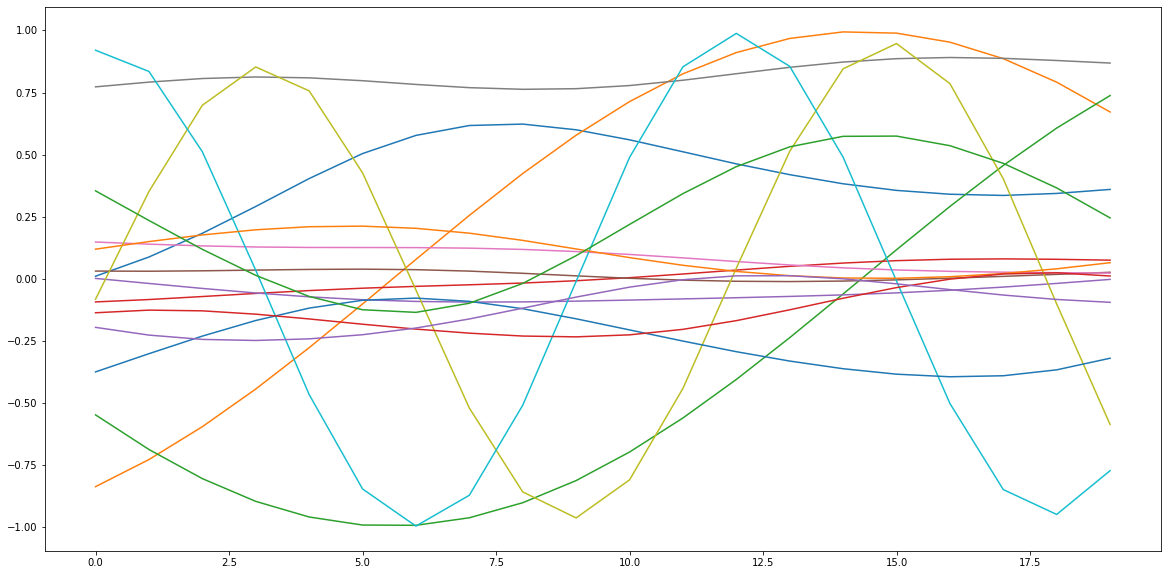

In [46]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
plt.plot(X_train_concat_flatten[optimizer.start_from].reshape([20,15]))
plt.show()

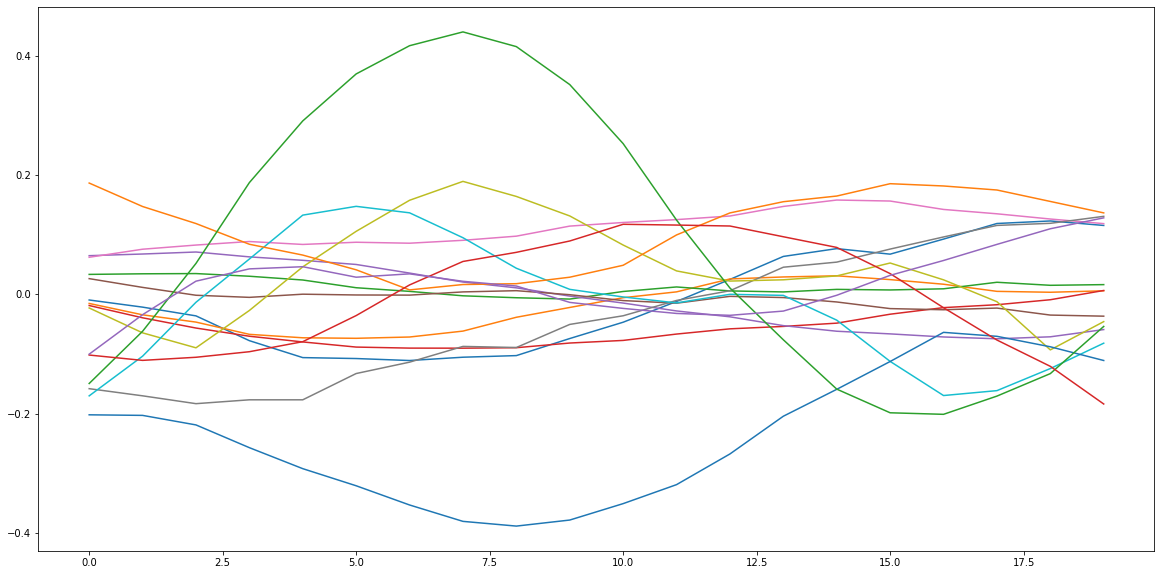

In [44]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(flds[:20])
plt.show()

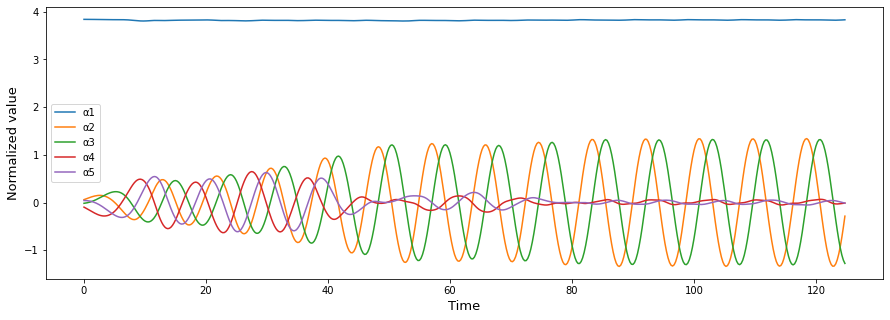

In [129]:
fig, ax = plt.subplots(1,1, figsize=[15,5])
ax.plot(np.arange(0,500/4,0.25),csv_data[:500,:5])
plt.xlabel("Time",{"fontsize":13})
plt.ylabel("Normalized value",{"fontsize":13})
plt.legend( ["α" + str(i) for i in range(1,6)])

plt.show()

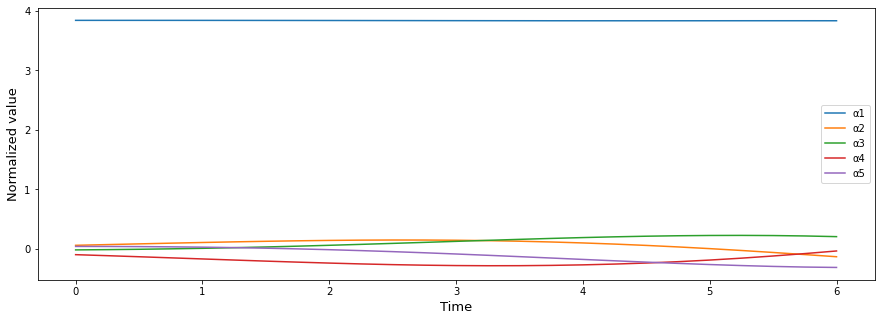

In [132]:
fig, ax = plt.subplots(1,1, figsize=[15,5])
ax.plot(np.arange(0,25/4,0.25),csv_data[:25,:5])
plt.xlabel("Time",{"fontsize":13})
plt.ylabel("Normalized value",{"fontsize":13})
plt.legend( ["α" + str(i) for i in range(1,6)])

plt.show()

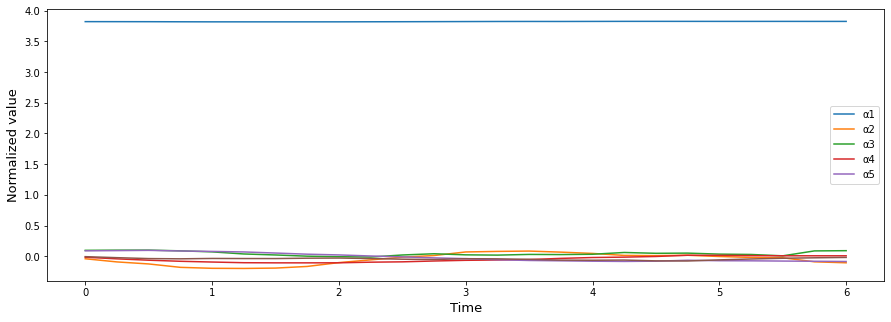

In [138]:
fig, ax = plt.subplots(1,1, figsize=[15,5])
ax.plot(np.arange(0,6.25,0.25),scaler.inverse_transform((flds+0.5))[:,:6])
plt.xlabel("Time",{"fontsize":13})
plt.ylabel("Normalized value",{"fontsize":13})
plt.legend( ["α" + str(i) for i in range(1,6)])

plt.show()

In [22]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')

In [36]:
(basis @ flds.T).shape

(18564, 25)

In [29]:
basis.shape

(18564, 15)

In [92]:
snapshots_grids = np.load("../data/processed/snaphsots_field_Velocity.npy")

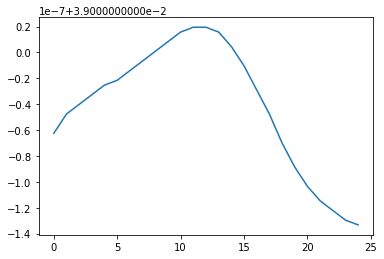

In [117]:
plt.plot(snapshots_grids[0][0][:25])

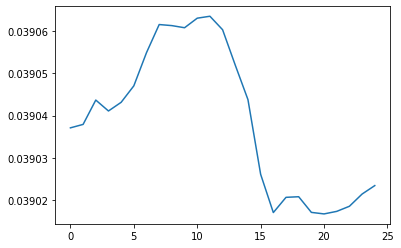

In [116]:
plt.plot((basis @ scaler.inverse_transform(flds+0.5).T)[0])

In [119]:
np.save('../data/reconstructed/velocity_field.npy', np.reshape((basis @ scaler.inverse_transform((flds+0.5)).T), [1,2,221,42,-1]))

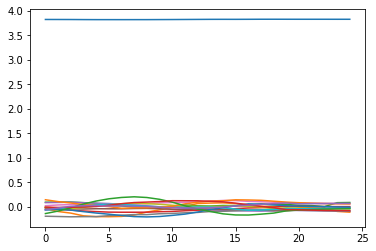

In [113]:
plt.plot(scaler.inverse_transform((flds+0.5)))

#### plt.plot(snapshots_grids[0][6])

In [ ]:
def reconstruct(basis, eigenvalues, plot=True, images=4):
    n, m = eigenvalues.T.shape
    m = min([images, m])
    indexes = np.arange(n)
    
    fig, ax = plt.subplots(2,2, figsize=[20,10])
    

    for i in range(m):
        tmp_diag = np.zeros_like(basis)
        #tmp_diag[indexes, indexes] = scaling.inverse_transform([eigenvalues_tmp[:,i]])
        
        (tmp_diag.T @ basis).shape
        print(basis @ tmp_diag)
        im = ax.flatten()[i].imshow(basis @ tmp_diag @ basis)


        

In [ ]:
mult = 7
noise = tf.random.normal(shape=[mult, 100])
X_generated = scaler.inverse_transform((gan.generator.predict(noise).reshape(mult*15,20)+1)/2)
plt.plot(X_generated[:,4])
plt.show()

In [93]:
snapshots_grids.shape

(1, 18564, 200)

In [95]:
np.reshape(snapshots_grids , [1,221,42,2,200]).shape

(1, 221, 42, 2, 200)